### Alignment b/w Prod and Dev on 2/19/2021
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load final data computed locally
# df = pd.read_feather("../../data/combined_all_features/combined_1613851268.feather") 
# we've previous sent combined_1613851268.feather to s3, let's download it
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df = pd.read_parquet(dev_path)
df = mu.prep_customer_data(df)
df_dev = df[df.is_static & (df.sample_date == df.sample_date.max())]
df_dev.sample_date.value_counts(), df_dev.shape

(2021-02-19    740625
 Name: sample_date, dtype: int64,
 (740625, 98))

In [3]:
# get production data
df_prod = pd.read_parquet('s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/prod-data-2021-02-19.parquet')

<AxesSubplot:>

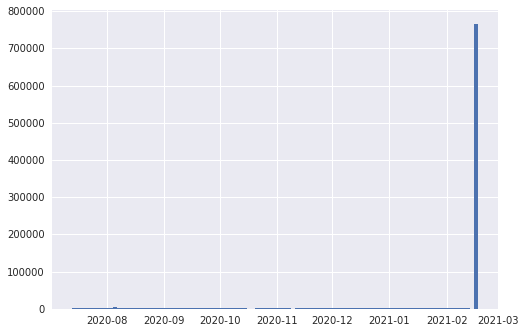

In [4]:
df_prod["last_checked_dt"] = pd.to_datetime(df_prod.last_checked_date.apply(lambda s: s.split()[0]))
df_prod["last_checked_dt"].hist(bins=100)

<AxesSubplot:>

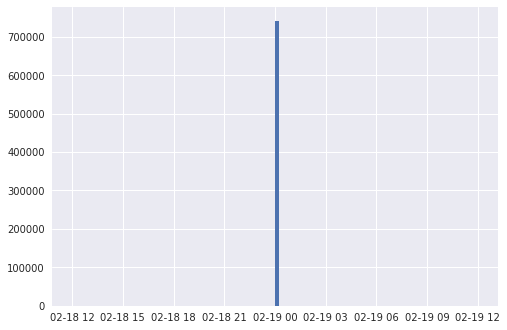

In [5]:
df_dev.sample_date.hist(bins=100)

### Repeated party_ids...
---

* "updated_dt will be later than last_checked_date if they get a new row"
* "they get a new row when they are assigned a new risk group"

Probably just some bug in the prod system..

In [7]:
# load meta data for debugging
# meta = pd.read_feather("../../data/raw/raw_1613955411/user_metadata_dw_1613955411.feather")

In [8]:
s = df_prod.party_id.value_counts()
mult_ids = s[s > 1].index
df_tmp = df_prod[df_prod.party_id.isin(mult_ids)]

In [9]:
len(mult_ids)

6138

In [10]:
df_tmp.head(6)  

,party_id,created_dt,updated_dt,last_checked_date,last_checked_date_max,risk_group,request_source,model_score,model_decision_rule_details,mcustomer_model_risk_groupodel_score,...,total_tradelines_open,education_loan_amount,iqt9415,iln5520,iqt9413,credit_card_loan_amount,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded,last_checked_dt
600,12976160,2020-08-07 23:13:32.284,2020-09-02 06:03:11.086,2020-08-07 23:13:32.261,2020-08-07 23:13:32.261,"""RG5""","""onboarding""",681.562354,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2020-08-07
601,12976160,2020-08-07 23:13:25.665,2020-08-07 23:13:32.261,2020-08-07 23:13:32.261,2020-08-07 23:13:32.261,"""RG5""","""onboarding""",661.184667,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2020-08-07
1343,13259309,2020-08-05 07:11:44.400,2020-09-02 06:19:39.727,2020-08-05 07:11:44.384,2020-08-05 07:11:44.384,"""RG5""","""scheduled""",590.904183,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2020-08-05
1344,13259309,2020-08-04 06:30:15.866,2020-08-05 07:11:44.384,2020-08-05 07:11:44.384,2020-08-05 07:11:44.384,"""RG5""","""return""",592.942016,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG4""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2020-08-05
1815,11799555,2020-08-04 22:16:02.343,2020-08-05 07:15:46.571,2020-08-04 22:16:02.334,2020-08-04 22:16:02.334,"""RG5""","""onboarding""",673.758389,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2020-08-04
1816,11799555,2020-08-04 22:13:15.595,2020-08-04 22:16:02.334,2020-08-04 22:16:02.334,2020-08-04 22:16:02.334,"""RG5""","""onboarding""",661.184667,"[{""ruleName"":""isMember"",""rulePassed"":false,""ri...","""RG5""",...,NaN,NaN,NaN,NaN,NaN,NaN,0,-1.0,-1.0,2020-08-04


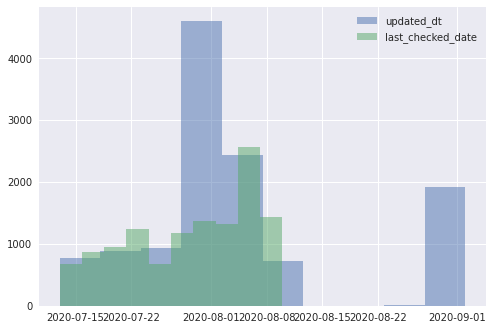

In [12]:
import matplotlib.pyplot as plt
df_tmp["updated_dt"] = pd.to_datetime(df_tmp.updated_dt.apply(lambda s: s.split()[0]))

fig = plt.figure()
df_tmp["updated_dt"].hist(label="updated_dt", alpha=0.5)
df_tmp.last_checked_dt.hist(label="last_checked_date", alpha=0.5)

plt.legend()
plt.show()

### Misalignment between Prod and Dev
---

In [13]:
# drop duplicated last_checked_date based on updated_dt
# keep the last one
df_prod = df_prod.sort_values(["party_id", "updated_dt"])
df_prod = df_prod.drop_duplicates(["party_id"], keep="last")

In [14]:
df_dev.shape, df_prod.shape

((740625, 98), (898814, 57))

In [15]:
dev_ids = set(df_dev.party_id)
prod_ids = set(df_prod.party_id)
shared_ids = dev_ids.intersection(prod_ids)
id_dev_only = dev_ids - prod_ids
id_prod_only = prod_ids - dev_ids
len(shared_ids), len(id_dev_only), len(id_prod_only)

(738187, 2438, 160627)

Dev side missing is negligible comparing to the prod side. Where are those data from?

In [ ]:
16518816， 18159873

In [ ]:
# print meta of dev only ids
meta[meta.user_id.isin(id_dev_only)].head(2)

In [ ]:
# print meta of prod only ids
meta[meta.user_id.isin(id_prod_only)].head(2)

In [48]:
list(id_prod_only)[:10]

[16777221,
 16777225,
 16777232,
 17825812,
 17825814,
 17825815,
 16777257,
 16777258,
 16777261,
 16777262]

In [49]:
tuple(id_prod_only)[:10]

(16777221,
 16777225,
 16777232,
 17825812,
 17825814,
 17825815,
 16777257,
 16777258,
 16777261,
 16777262)

In [51]:
print("""10602605
10602609
10602616
10602641
10602642
10602645
10602646
11648640
11648642
11648643
""".split())

['10602605', '10602609', '10602616', '10602641', '10602642', '10602645', '10602646', '11648640', '11648642', '11648643']


#### Get some ids that `was` active in dev

In [54]:
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df_dy = pd.read_parquet(dev_path)
df_dy = df_dy[~df_dy.is_static]

<AxesSubplot:>

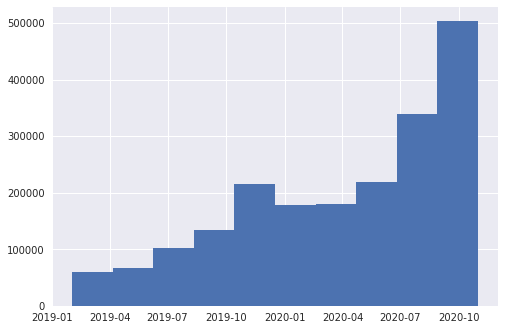

In [55]:
df_dy.sample_date.hist()

In [56]:
import rdsutils.query as query

#### get all banking accounts along with their ids and active flag on 2/22/2021

In [117]:
q = """
SELECT DISTINCT badf.borrower_id, ba.active_flag, b.user_id,
                b.updated_date as b_updated_dt,
                ba.updated_date as ba_updated_dt
 FROM banking_account_daily_facts badf
 JOIN banking_accounts ba ON badf.banking_account_id = ba.banking_account_id
 JOIN borrowers b ON b.borrower_id = badf.borrower_id
""" # WHERE product_type='SoFi Money Cash Account'
%time bid_df = query.query_postgres(q, port = 15501)

CPU times: user 18.4 s, sys: 2.43 s, total: 20.8 s
Wall time: 7min 17s


In [118]:
bid_df.shape, bid_df.active_flag.value_counts()

((5687306, 5),
 False    4854309
 True      832997
 Name: active_flag, dtype: int64)

In [119]:
df_tmp = bid_df[bid_df.borrower_id == 5410623]
df_tmp.b_updated_dt.nunique(), df_tmp.ba_updated_dt.nunique(), df_tmp.badf_updated_dt.nunique()

AttributeError: 'DataFrame' object has no attribute 'badf_updated_dt'

In [ ]:
bid_df[bid_df.borrower_id == 5410623]

In [ ]:
bid_df.to_parquet("../../artifacts/bid_active_flag_20210222.parquet")

In [ ]:
len(id_prod_only), len(id_dev_only)

In [ ]:
# dev only accounts on 2/21/2021
inactive_in_dev = bid_df[(~bid_df.active_flag) & (bid_df.user_id.isin(id_dev_only))]
active_in_dev = bid_df[(bid_df.active_flag) & (bid_df.user_id.isin(id_dev_only))]
print("num inactive accounts in dev only ids")
print("num active accounts in dev only ids")
inactive_in_dev.shape, active_in_dev.shape

In [ ]:
# prod only accounts on 2/21/2021
inactive_in_prod = bid_df[(~bid_df.active_flag) & (bid_df.user_id.isin(id_prod_only))]
active_in_prod = bid_df[(bid_df.active_flag) & (bid_df.user_id.isin(id_prod_only))]
print("num inactive accounts in prod only ids")
print("num active accounts in prod only ids")
print("""there are 160k prod only ids in total, meaning a
         meaning 130k """)
inactive_in_prod.shape, active_in_prod.shape

In [ ]:
bid_df.user_id.value_counts().sort_values("")

In [ ]:
bid_df.shape, bid_df.user_id.nunique(), bid_df.borrower_id.nunique()

In [ ]:
len(id_prod_only), len(set(bid_df.user_id.unique()))

In [ ]:
print("party_ids that showed up in the production env but not in dev db")
len(id_prod_only - set(bid_df.user_id.unique()))

In [67]:
# inactive accounts on the entire dev data
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df_dev_full = pd.read_parquet(dev_path)

df_dev_full["party_id"] = df_dev_full["user_id"]
id_dev_full_only = set(df_dev_full.party_id) - set(df_prod.party_id)

In [82]:
inactive_in_dev = bid_df[(~bid_df.active_flag) & (bid_df.user_id.isin(id_dev_full_only))]
inactive_in_dev.shape

(47753, 3)

In [83]:
inactive_in_dev.head()

,borrower_id,active_flag,user_id
12,138,False,378
14,149,False,402
44,555,False,1940
92,1184,False,1853
138,1676,False,5532


### Compute Shifted PSI
---

In [16]:
# align ids 
df_dev = df_dev[df_dev.party_id.isin(shared_ids)]
df_prod = df_prod[df_prod.party_id.isin(shared_ids)]

In [17]:
# preprocess
df_dev = mu.prep_customer_data(df_dev)

In [18]:
# load model from s3
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [46]:
features = model.feature_name_
psi_df = mntr.get_psi(df_dev[features], df_prod[features], buckets=10).round(5)
# psi_df.to_csv(os.path.join(artifact_dir, f"{snapshot_date}_psi.csv"), index=False)
psi_df

,feature,psi
6,transaction_as_pct_of_balance,0.08423
37,age_money_account,0.05081
26,time_since_last_transaction,0.05066
38,transaction_code_encoded,0.04003
31,nr_trans_ratio,0.02150
9,name_address_correlation,0.01134
28,name_phone_correlation,0.01026
5,name_email_correlation,0.00983
32,iqt9413,0.00797
24,giact_nr_decline,0.00616


### Look at Feature Level

In [32]:
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

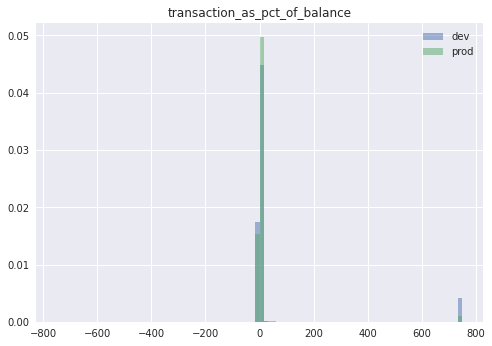

In [42]:
import matplotlib.pyplot as plt

feature = "transaction_as_pct_of_balance" # psi_df.feature.iloc[4]
fig = plt.figure()

df_dev[feature].hist(bins=100, alpha=0.5, label="dev", density=True)
df_prod[feature].hist(bins=100, alpha=0.5, label="prod", density=True)

plt.title(feature)
plt.legend()
plt.show()

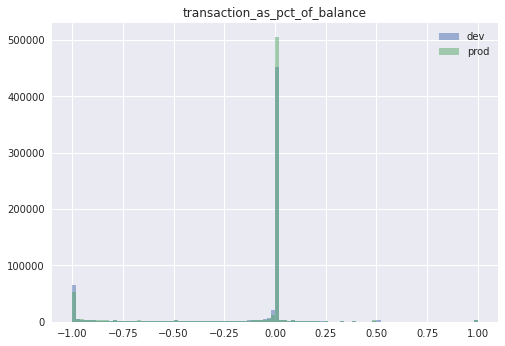

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure()

lower, upper = -1,1
df_dev[feature][df_dev[feature].between(lower,upper)].hist(bins=100, alpha=0.5, label="dev")
df_prod[feature][df_prod[feature].between(lower,upper)].hist(bins=100, alpha=0.5, label="prod")

plt.title(feature)
plt.legend()
plt.show()

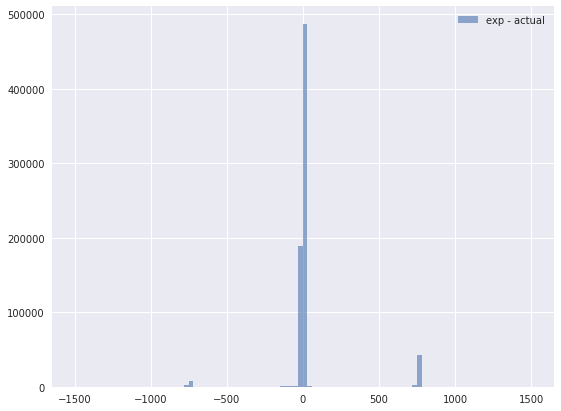

In [44]:
_ = plot_difference(df_dev[feature], df_prod[feature], bins=100)